What is mixed precision?

Mixed precision is the switching between floating point 16 and floating point 32 to accelerate model training

In google colab, the nvidia GPUs supporting mixed precision training are the ones with compute capability of 7 or more (Tesla T4)

In [1]:
# to find the GPU being used, we can do the following
# If tesla T4 is being used, then we can make use of the mixed precision training
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-257e5de7-0c8b-a5a1-ee29-bd1b5d38f0fe)


In [2]:
# next we will download the helper function which contains some useful functions 
# for model tracking and performance
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-11 14:21:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-11 14:21:15 (89.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback,compare_historys,plot_loss_curves

In [4]:
# next we will import tensorflow and tensorflow datasets which contain ready datasets that can be downloaded
# from the module

import tensorflow as tf

In [5]:
import tensorflow_datasets as tfds

In [6]:
# find all the available datasets in tfds

dataset_list=tfds.list_builders()

In [7]:
len(dataset_list)# this has 224 datasets

224

In [8]:
# we want to check if food vision 101 is there in the dataset_list
"food101" in dataset_list

True

In [9]:
# now we will load the dataset using tfds.load()

(train_data,test_data),ds_infor=tfds.load(name="food101",split=["train","validation"],
                                          shuffle_files=True,
                                          as_supervised=True,
                                          with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete1PIBGF/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete1PIBGF/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [10]:
# now we will explore the data

ds_infor.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [11]:
class_names=ds_infor.features['label'].names

In [12]:
# displaying the top 10 classes
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [13]:
type(ds_infor.features['image'])

tensorflow_datasets.core.features.image_feature.Image

In [14]:
# take one sample from the training datasets
training_sample=train_data.take(1)

In [15]:
training_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [39]:
# output some infor from that
for image,label in training_sample:
  print(f'the shape of image is{image.shape}')
  print(f'the label is {label}')

the shape of image is(512, 512, 3)
the label is 56


In [19]:
# now let's plot one image
import matplotlib.pyplot as plt

In [40]:
for image,label in training_sample:
  print(f'the shape of image is{image.shape}')
  print(f'the label is {label}')

the shape of image is(512, 289, 3)
the label is 45


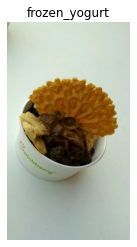

In [41]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

In [42]:
# now we need to create some preprocessing functions to prepare images before passing them to a neural
# network

# first need to normalize the image between 0 and 1
# also need to set the image size to be fixed size
# also need to set batch size

type(train_data)

tensorflow.python.data.ops.dataset_ops._OptionsDataset

In [36]:
image[1]

<tf.Tensor: shape=(512, 3), dtype=uint8, numpy=
array([[ 43,  46,  25],
       [ 46,  49,  28],
       [ 49,  54,  32],
       ...,
       [ 95, 122,  77],
       [ 90, 117,  72],
       [ 83, 110,  65]], dtype=uint8)>

In [43]:
len(train_data),len(test_data)
# this is the length of the training data


(75750, 25250)

In [44]:

def preprocessing_images(image,label,shape=224):

  '''
    Parameters: Image (Tensor)
              Label: Tensor Shape of numpy integer
              shape=224

    Returns:
          Tuple (Preprocessed_image,label)
  '''

  # first resize the image
  image=tf.image.resize(image,size=(shape,shape))

  # change the datatype and return it

  return tf.cast(image,dtype=tf.float32),label


In [53]:
label

<tf.Tensor: shape=(), dtype=int64, numpy=45>

In [54]:
preprocessed_image,preprocessed_label=preprocessing_images(image,label)

In [55]:
preprocessed_image,label

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[147.19739, 153.19739, 127.19739],
         [157.22768, 163.22768, 137.22768],
         [158.09805, 164.09805, 138.09805],
         ...,
         [197.     , 209.     , 197.54907],
         [197.     , 209.     , 199.     ],
         [198.09914, 208.38936, 199.24425]],
 
        [[154.69467, 160.69467, 134.69467],
         [155.87053, 161.87053, 135.87053],
         [158.39908, 164.39908, 138.39908],
         ...,
         [197.     , 209.     , 197.54907],
         [197.     , 209.     , 199.     ],
         [196.32831, 206.61853, 195.76364]],
 
        [[154.56473, 158.56473, 133.56473],
         [153.49234, 158.17635, 132.83435],
         [157.76036, 163.3318 , 137.54608],
         ...,
         [197.     , 209.     , 197.54907],
         [197.     , 209.     , 197.87054],
         [197.85489, 208.51149, 197.1832 ]],
 
        ...,
 
        [[176.88599, 189.88599, 180.88599],
         [175.68573, 188.96552, 179.87225]

Batch and preprocess the datasets

In [56]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocessing_images, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocessing_images, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [57]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

Creating model callbacks

In [58]:
from helper_functions import create_tensorboard_callback

In [59]:
# create model checkpoint
checkpoint_path="model_checkpoint/cp.ckpt"
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    monitor='val_acc',
                                                    save_best_only=True,
                                                    save_weights_only=True)

In [60]:
# setting up mixed precision training
from tensorflow.keras import mixed_precision

In [61]:
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [62]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [63]:
# creating a feature extraction model

In [64]:
input_shape=(224,224,3)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# create an input layer
inputs=tf.keras.layers.Input(input_shape,name="input_layer")

x=base_model(inputs,training=False)

x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)

x=tf.keras.layers.Dense(101)(x)

outputs=tf.keras.layers.Activation("softmax",
                                   dtype=tf.float32,
                                   name="softmax_tffloat32")(x)

model=tf.keras.Model(inputs,outputs)


16719872/16705208 [==============================] - 0s 0us/step


In [65]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [66]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_tffloat32 (Activati  (None, 101)              0         
 on)                                                             
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [67]:
# checking to see if the model is using tf.float32
for layer in model.layers:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_tffloat32 True float32 <Policy "float32">


Layer.dtype represents the data stored (float 32)

layer.dtype_policy represents the data computations are performed on (float 16)

In [68]:
# finding the dtype_policy in baseline model
for layer in base_model.layers:
  print(layer.dtype,layer.dtype_policy)

float32 <Policy "float32">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy "mixed_float16">
float32 <Policy 

In [69]:
# now we can fit the model

history_101_food_classes_feature_extract=model.fit(train_data,epochs=3,
          steps_per_epoch=len(train_data),
          validation_data=test_data,
          validation_steps=int(0.15*len(test_data)),
          callbacks=[create_tensorboard_callback("training_logs","efficientnetB0_allclasses_mixedprecision"),
                     model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetB0_allclasses_mixedprecision/20220711-144813
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8203 - accuracy: 0.5563WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 191s 72ms/step - loss: 1.8203 - accuracy: 0.5563 - val_loss: 1.2240 - val_accuracy: 0.6766
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.2927 - accuracy: 0.6665WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 164s 68ms/step - loss: 1.2927 - accuracy: 0.6665 - val_loss: 1.1167 - val_accuracy: 0.7050
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1428 - accuracy: 0.7033WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 163s 68ms/step - loss: 1.1428 - accuracy: 0.7033 - val_loss: 1.0811 - val_accuracy: 0.7087


In [70]:
!mkdir -p saved_model

In [72]:
saved_model=model.save("/content/saved_model")

INFO:tensorflow:Assets written to: /content/saved_model/assets


INFO:tensorflow:Assets written to: /content/saved_model/assets


In [75]:
# load the saved model
loaded_model=tf.keras.models.load_model("/content/saved_model")

In [76]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_tffloat32 (Activati  (None, 101)              0         
 on)                                                             
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# check the layers in base model

for layer in base_model.layers:
  print(layer.dtype,layer.dtype_policy)

In [78]:
# check the performance of the loaded model

loaded_model.evaluate(test_data)

790/790 [==============================] - 53s 64ms/step - loss: 1.0814 - accuracy: 0.7088


[1.0814340114593506, 0.7087920904159546]

The feature extraction model is very close to the results obtained from the deep food paper (70% validation accuracy)

In [79]:
# we will build a fine tuned model to try and enhance the validation accuracy

for layer in loaded_model.layers:
  print(layer.trainable)

True
False
True
True
True


In [80]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_tffloat32 (Activati  (None, 101)              0         
 on)                                                             
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [87]:
# now check the trainable layers in the base mode

loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_tffloat32 (Activati  (None, 101)              0         
 on)                                                             
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [92]:
# Download and evaluate fine-tuned model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip

--2022-07-11 15:31:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.183.128, 173.194.196.128, 173.194.198.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.183.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46790356 (45M) [application/zip]
Saving to: ‘07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  44.62M  68.5MB/s    in 0.7s    

2022-07-11 15:31:25 (68.5 MB/s) - ‘07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip’ saved [46790356/46790356]



In [93]:
# Unzip fine-tuned model
!mkdir downloaded_fine_tuned_gs_model # create separate directory for fine-tuned model downloaded from Google Storage
!unzip /content/07_efficientnetb0_fine_tuned_101_classes_mixed_precision -d downloaded_fine_tuned_gs_model

Archive:  /content/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/variables.index  
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/saved_model.pb  
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets/


In [94]:
# Load in fine-tuned model from Google Storage and evaluate
loaded_fine_tuned_gs_model = tf.keras.models.load_model("/content/downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

In [95]:
loaded_fine_tuned_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-train

In [97]:
results_downloaded_fine_tuned_gs_model = loaded_fine_tuned_gs_model.evaluate(test_data)
results_downloaded_fine_tuned_gs_model

790/790 [==============================] - 55s 65ms/step - loss: 0.9073 - accuracy: 0.8017


[0.9072546362876892, 0.8017029762268066]

In [104]:
base_model_layers=loaded_fine_tuned_gs_model.layers[1].layers


In [ ]:
for layer in base_model_layers:
  print(layer.trainable)

In [ ]:
s

In [106]:
!tensorboard dev upload --logdir ./training_logs \
  --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
  --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./training_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=NVTjslOztgYCmV3UCYNQL4JAyRzlOU&prompt=consent&access_type=offli

In [108]:
!tensorboard dev list

https://tensorboard.dev/experiment/eZQTEw6vR72uAeMdo2Xb7g/
	Name                 Fine-tuning EfficientNetB0 on all Food101 Data
	Description          Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001
	Id                   eZQTEw6vR72uAeMdo2Xb7g
	Created              2022-07-11 15:40:34 (54 seconds ago)
	Updated              2022-07-11 15:40:36 (52 seconds ago)
	Runs                 4
	Tags                 5
	Scalars              24
	Tensor bytes         0
	Binary object bytes  2154748
https://tensorboard.dev/experiment/VV3ewMzASbmvGN02RjgNEw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   VV3ewMzASbmvGN02RjgNEw
	Created              2022-06-30 18:12:27
	Updated              2022-06-30 18:12:33
	Runs                 6
	Tags                 5
	Scalars              90
	Tensor bytes         0
	Binary obj